### Malicious URL Detector

In [ ]:

# Load modules and dependencies
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:

# Mount the colab to the g-drive if necessary
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your own directory where the data is located.


%cd /content/drive/MyDrive/urls/urls


/content/drive/MyDrive/urls/urls


In [ ]:
# Check if in the right directory with necessary data files
!ls

ger_flag.png	      legitimate_urls2.csv	      phishing_urls1.csv
legitimate_urls1.csv  phishingandlegitimate_urls.csv  phishing_urls2.csv


In [ ]:
# read all datasets 

a = pd.read_csv('phishingandlegitimate_urls.csv')
b = pd.read_csv('phishing_urls1.csv')
c = pd.read_csv('phishing_urls2.csv')
d = pd.read_csv('legitimate_urls1.csv')
e = pd.read_csv('legitimate_urls2.csv')



In [ ]:
# Concate them together

df = pd.concat([a,b,c,d,e ]).reset_index(drop=True)
df['Label'].unique()

# Binarize the label as "phishing": 1, "legitimate": 0
df["Label"].replace({"phishing": 1, "legitimate": 0}, inplace=True)

# Shuffle data
df = df.sample(frac=1)
df.head()

,URL,Label
419004,quennevillefamilyhistory.com/html/names17.html,0
561151,http://keciorenmentalaritmetik.net/wp-content/...,1
388735,mfhn.com/lalonde/i881.asp,0
420491,rci.rutgers.edu/~avhorw/content.html,0
762911,http://www.paypal-financial.de/12208/index.php,1


In [ ]:
# Here you can define the size of the dataset.

df1 = df.iloc[:len(df*1),] # df1 x 1 means full data set
len(df1)

1091334

In [ ]:
# Define initial parameters for tockenizer
vocab_size = 5000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [ ]:
# Determine training size
split = 0.15
training_size = int(round(len(df1)*(1-split),0))


In [ ]:

# we are doing this because Pandas series faces some problem tf adaptations

text = [url for url in df1['URL']]
Label= df1['Label'].values


In [ ]:
# Define initial parameters for tockenizer
vocab_size = 70000
embedding_dim = 15
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"



In [ ]:
# split into train amd test sets

training_sentences = text[0:training_size]
testing_sentences = text[training_size:]
training_labels = Label[0:training_size]
testing_labels = Label[training_size:]
len(training_labels)

927634

In [ ]:
# Create token and sequence

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Define optimizer
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")


In [ ]:
# Adding batch normalization
# Doesn't improve model accuracy, osscilates

batch_norm = tf.keras.layers.BatchNormalization(
    axis=1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)
# Excluded from the model due to inefficiency

In [ ]:
# Define model
layer = tf.keras.layers
model = tf.keras.Sequential([
    layer.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layer.GlobalAveragePooling1D(),
    layer.Dense(512, activation='relu'),
    layer.Dense(128, activation='softmax'),
    layer.Dense(24, activation='relu'),
    layer.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 15)           1050000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               8192      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 1,126,977
Trainable params: 1,126,977
Non-trainable params: 0
______________________________________________

In [ ]:
# Call back for early stopping
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('val_accuracy') > 0.9755:
                print("\Defined accuracy is reached and cancelling the training")
                self.model.stop_training = True

callback = myCallback()


In [ ]:
num_epochs = 50
batch_size = 512
history = model.fit(training_padded, training_labels, epochs = num_epochs,batch_size=batch_size, 
                    validation_data=(testing_padded, testing_labels), verbose=2, callbacks= [callback])

Epoch 1/50
1812/1812 - 24s - loss: 0.1934 - accuracy: 0.9152 - val_loss: 0.0942 - val_accuracy: 0.9664
Epoch 2/50
1812/1812 - 21s - loss: 0.0823 - accuracy: 0.9709 - val_loss: 0.0847 - val_accuracy: 0.9700
Epoch 3/50
1812/1812 - 20s - loss: 0.0745 - accuracy: 0.9734 - val_loss: 0.0839 - val_accuracy: 0.9695
Epoch 4/50
1812/1812 - 20s - loss: 0.0704 - accuracy: 0.9746 - val_loss: 0.0825 - val_accuracy: 0.9697
Epoch 5/50
1812/1812 - 20s - loss: 0.0685 - accuracy: 0.9748 - val_loss: 0.0820 - val_accuracy: 0.9700
Epoch 6/50
1812/1812 - 20s - loss: 0.0668 - accuracy: 0.9756 - val_loss: 0.0885 - val_accuracy: 0.9674
Epoch 7/50
1812/1812 - 20s - loss: 0.0647 - accuracy: 0.9761 - val_loss: 0.0839 - val_accuracy: 0.9713
Epoch 8/50
1812/1812 - 20s - loss: 0.0627 - accuracy: 0.9764 - val_loss: 0.0785 - val_accuracy: 0.9702
Epoch 9/50
1812/1812 - 20s - loss: 0.0596 - accuracy: 0.9771 - val_loss: 0.0808 - val_accuracy: 0.9702
Epoch 10/50
1812/1812 - 20s - loss: 0.0580 - accuracy: 0.9777 - val_loss:

In [ ]:
# Check the max val_accuracy and corresponding accuracy 

d = pd.DataFrame(history.history['val_accuracy'])
d.max()

0    0.97474
dtype: float64

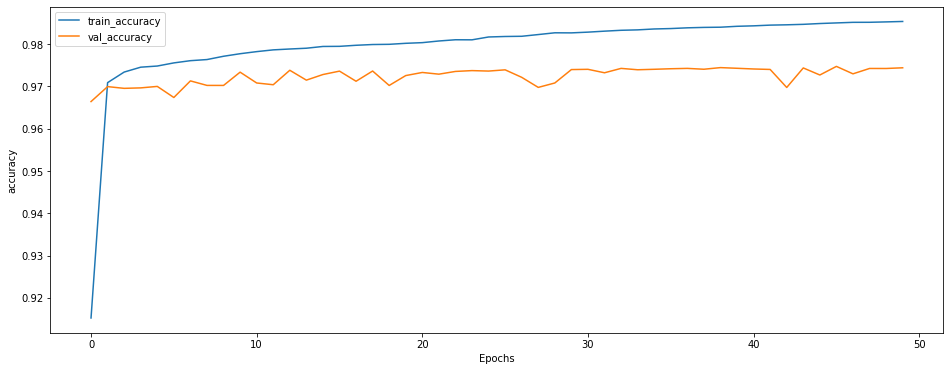

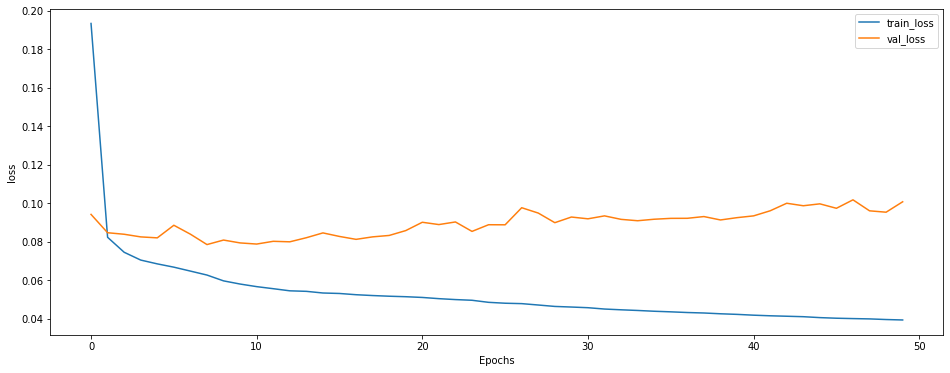

In [ ]:
# Plotting

def plot_graphs(history, string):
   
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  plt.show()
  
plt.rcParams["figure.figsize"] = (16,6)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:

# Model evaluate & predict
# Model save and load again

#### Can we Improve more??


* Try different types of optimizers??
* We can use Anita's Logistic Classifier to compare Statistical vs Deep-Learning approach.
* Include Anit's heat-plot and images into the ppt. 
* Finally, we can discuss bit about the tools we used (optimzer, cost function etc)??
* We can add more data??
* We can include call back 




#### Other people's work:

* MPFD method (CNN + LSTM): Accuracy 99.4-99.6 %
* Another approach only with CNN